# WSI - ćwiczenie 5 - Sztuczne sieci neuronowe
*Tomasz Żebrowski, Tomasz Frankowski*

Celem zadania była implementacja perceptronu wielowarstwowego oraz odpowiedniego algorytmu służąceg odo optymalizacji jego wag. Nasza implementacja znajduje się w pliku `mpl.py`. Najważniejszym jego elementem jest klasa `MLP` realizująca oba zadania. Posiada ona m.in. metody `predict` i `fit`. Pierwsza realizuje wyznaczanie wyjść perceptronu dla zadanych wejść, druga natomiast realizuje uczenie sieci z wykorzystaniem algorytmu optymalizacji gradientowej. Dodatkowo, w pliku tym zaimplementowane są funkcje aktywacji neuronu oraz ich pochodne.

Pracę, zgodnie ze wskazówką, rozpoczynamy od weryfikacji poprawności działania zaimplementowanych elementów na zadaniu XOR.

In [3]:
import numpy as np
from mlp import MLP, elu, d_elu_dt
# Definicja zadania xor
X_xor_train = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_xor_train = np.array([[0], [1], [1], [0]])
# Zaproponowana struktura sieci - 3 neurony w jednej warstwie ukrytej
mlp = MLP(2, 3, 1, 1, elu, d_elu_dt)
mlp.fit(X_xor_train, y_xor_train, 2137, 0.1)
y_xor_pred = mlp.predict(X_xor_train)
for i, x in enumerate(X_xor_train):
    print(x,"-> ", "%.1f" % y_xor_pred[i][0])

[0 0] ->  0.0
[0 1] ->  1.0
[1 0] ->  1.0
[1 1] ->  0.0


Wynik jest obiecujący. Perceptron prawidłowo realizuje funkcję XOR. Dla zapewnienia sobie dodatkowej pewności, testujemy go na zadaniu aproksymacji funkcji kwadratowej.

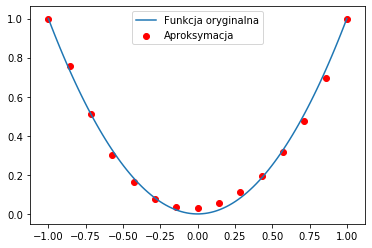

In [4]:
import matplotlib.pyplot as plt

X_square_train = np.linspace(-1, 1, 100)
y_square_train = np.array([x**2 for x in X_square_train])
X_square_train = np.array([[x] for x in X_square_train])
y_square_train = np.array([[y] for y in y_square_train])

X_square_test = np.linspace(-1, 1, 15)
y_square_test = np.array([x**2 for x in X_square_test])
X_square_test = np.array([[x] for x in X_square_test])
y_square_test = np.array([[y] for y in y_square_test])

mlp = MLP(1, 3, 2, 1, elu, d_elu_dt)
mlp.fit(X_square_train, y_square_train, 1519, 0.1)
y_predict = mlp.predict(X_square_test)

plt.plot(X_square_train, y_square_train, label="Funkcja oryginalna")
plt.scatter(X_square_test, y_predict, color="red", label="Aproksymacja")
plt.legend()
plt.show()

Ponownie, obserwujemy poprawne działanie perceptronu. Możemy przejść do przygotowania danych z zadanego zbioru.

### Przygotowanie danych

Rozpoczynamy od pobrania zbioru danych. Wykorzystujemy do tego funkcję `load_wine`  z pakietu *scikit-learn*. Sprawdzamy liczbę klas i parametrów. Poniżej przedstawiamy wynik.

In [5]:
from sklearn.datasets import load_wine
data = load_wine()
X = data.data
y = data.target
class_names = data.target_names
feature_names = data.feature_names
print("Liczba parametrów:", len(feature_names))
print("Liczba klas:", len(class_names))

Liczba parametrów: 13
Liczba klas: 3


Dane dzielimy na podzbiory uczący i testowy w stosunku 4:1

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
print("Liczność zbioru uczącego:", len(X_train))
print("Liczność zbioru testowego:", len(X_test))

Liczność zbioru uczącego: 142
Liczność zbioru testowego: 36


Konieczne jest odpowiednie przetworzenie danych. Elementy zbioru y są liczbami odpowiadającymi numerowi klasy, natomiast nam zależy na szeregu liczb odpowiadającym przynależności do każdej z klas (Ponieważ takie wyjścia będzie miał perceptron). Dodatkowo, wszystkie parametry skalujemy tak, by ich odchylenie standardowe było równe 1, a średnia 0. Wpłynie to pozytywnie na wyniki eksperytmentów.

In [7]:
from sklearn.preprocessing import LabelBinarizer
binarizer = LabelBinarizer()
y_train = binarizer.fit_transform(y_train)
y_test = binarizer.transform(y_test)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Tak przygotowane dane podajemy do perceptronu (o założonej z góry, dość losowej strukturze) i sprawdzamy co z tego wyjdzie.

In [24]:
mlp = MLP(13, 5, 2, 3, elu, d_elu_dt)
mlp.fit(X_train, y_train, 500, 0.0001)

In [26]:
from mlp import accuracy
y_pred = mlp.predict(y_train)
acc = accuracy(np.argmax(y_train, axis=1), np.argmax(y_pred, axis=1))
print("Dokładność na zbiorze uczącym:", "%.2f%%" % (acc*100))

Dokładność na zbiorze uczącym: 71.83%


Wynik wyznaczony na zbiorze testowym jest dość dobry, jednak sądzimy, że może być lepiej. Testujemy sieci o różnej  strukturze korzystając z walidacji krzyżowej do wyznaczania ich jakości.

In [10]:
from datetime import datetime
n_hidden = [1, 2, 3]
n_neurons = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
index = 0
total = len(n_hidden) * len(n_neurons)
results = {}

for h in n_hidden:
    for n in n_neurons:
        print("Postęp:", "%.2f%%" % (index/total*100), end="\r")
        mlp = MLP(13, n, h, 3, elu, d_elu_dt)
        time = datetime.now()
        score = mlp.cross_validate(3, X_train, y_train, 666, 0.0001)
        time = datetime.now() - time
        results[(h, n)] = (score, time)
        index += 1

/home/tototmek/Studia/22Z/WSI/mlp.py:31: RuntimeWarning: overflow encountered in double_scalars
  return activation(sum([i * w for i, w in zip(inputs, weights)]) + bias)
/home/tototmek/Studia/22Z/WSI/mlp.py:69: RuntimeWarning: overflow encountered in double_scalars
  deltas.append([sum([deltas[-1][k] * self.weights[i][k][j] for k in range(len(deltas[-1]))]) * self.d_activation_dt(outputs[i][j]) for j in range(len(outputs[i]))])
/home/tototmek/Studia/22Z/WSI/mlp.py:75: RuntimeWarning: overflow encountered in double_scalars
  self.weights[i][j][k] -= learning_rate * deltas[i][j] * outputs[i][k]
/home/tototmek/Studia/22Z/WSI/mlp.py:31: RuntimeWarning: invalid value encountered in double_scalars
  return activation(sum([i * w for i, w in zip(inputs, weights)]) + bias)
/home/tototmek/Studia/22Z/WSI/mlp.py:69: RuntimeWarning: invalid value encountered in double_scalars
  deltas.append([sum([deltas[-1][k] * self.weights[i][k][j] for k in range(len(deltas[-1]))]) * self.d_activation_dt(outputs

In [17]:
# display some best results as a table

print("Liczba warstw ukrytych\tLiczba neuronów\tDokładność\tCzas")
for (h, n), (acc, time) in sorted(results.items(), key=lambda x: np.mean(x[1][0]), reverse=True)[:10]:
    print(h, "\t\t\t", n, "\t\t", "%.2f%%" % (np.mean(acc)*100), "\t", time)



Liczba warstw ukrytych	Liczba neuronów	Dokładność	Czas
1 			 5 		 93.62% 	 0:00:10.788311
1 			 9 		 92.20% 	 0:00:18.061193
1 			 12 		 91.49% 	 0:00:23.825308
2 			 11 		 91.49% 	 0:00:37.442053
1 			 6 		 90.78% 	 0:00:12.643482
1 			 10 		 90.78% 	 0:00:19.988085
1 			 11 		 90.78% 	 0:00:21.950513
2 			 13 		 90.78% 	 0:00:46.575109
2 			 12 		 90.07% 	 0:00:41.519620
1 			 3 		 89.36% 	 0:00:06.918796


Widać, że osiągnięta została dobra dokładność. Najlepszą strukturą sieci do omawianego zadania okazuje się perceptron o jednej warstwie ukrytej posiadającej 5 neuronów. Zapewnia ona 93.62% dokładności oraz stosunkowow dobry czas wykonywania obliczeń. Nieintuicyjne wydawało się początkowo to, że sieci o większej głębokości radzą sobie gorzej. Prawdopodobnie wynika to z tego, że dochodzi w ich przypadku do przeuczenia - model słabo działa na danych walidacyjnych przy zbyt dużym dopasowaniu do danych uczących.

Powyższe eksperymenty były wykonane przy stałym tempie uczenia. Sprawdzamy, jak jego zmiana wpływa na zbieżność algorytmu optymalizacji.

In [10]:
lr = np.logspace(-6, -2, 12)
total = len(lr)
results_lr = {}
index = 0
X_train_lr, X_val_lr, y_train_lr, y_val_lr = train_test_split(X_train, y_train, train_size=0.666)
for l in lr:
    print("Postęp:", "%.2f%%" % (index/total*100), end="\r")
    mlp = MLP(13, 5, 1, 3, elu, d_elu_dt)
    history = mlp.fit(X_train, y_train, 666, l, validation_data=(X_val_lr, y_val_lr))
    results_lr[l] = history
    index += 1
print("Postęp: 100%     ", end="\r")